In [46]:
import math # for sqrt...
import pandas as pd
import numpy as np
import matplotlib as mpl
import seaborn as sb
from sklearn.model_selection import train_test_split # for train test split
from sklearn.metrics import mutual_info_score # for mutual information score
from sklearn.metrics import accuracy_score # for accuracy score
from sklearn.metrics import mean_squared_error # for q6
from sklearn.feature_extraction import DictVectorizer # for one-hot encoding
from sklearn.linear_model import LogisticRegression # for log reg
from sklearn.linear_model import Ridge # for q6
import pickle

from sklearn.metrics import roc_auc_score # for hw4 q1
from matplotlib import pyplot as plt # for hw4 q3
%matplotlib inline

In [4]:
df = pd.read_csv("AER_credit_card_data.csv")
# The goal of this homework is to inspect the output of different evaluation metrics 
# by creating a classification model (target column card).

In [5]:
# Preparation
# Create the target variable by mapping yes to 1 and no to 0.
df['card'] = df['card'].map(dict(yes=1, no=0)) # <-- target
df['owner'] = df['owner'].map(dict(yes=1, no=0))
df['selfemp'] = df['selfemp'].map(dict(yes=1, no=0))
# df.head()

In [6]:
# Split the dataset into 3 parts: train/validation/test with 60%/20%/20% distribution. 
# Use train_test_split funciton for that with random_state=1.
X_train_valid, X_test, y_train_valid, y_test = train_test_split(
    df.drop('card', axis = 1),
    df[['card']],
    train_size = 0.8,
    test_size = 0.2,
    random_state = 42)
# print(df.shape)
# print()
# print(X_train_valid.shape)
# print(y_train_valid.shape)
# print()
# print(X_test.shape)
# print(y_test.shape)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_valid,
    y_train_valid,
    train_size = 0.75,
    test_size = 0.25,
    shuffle = False)
# print(X_train.shape)
# print(y_train.shape)
# print()
# print(X_valid.shape)
# print(y_valid.shape)

In [7]:
# Question 1
# ROC AUC could also be used to evaluate feature importance of numerical variables.
# Let's do that

# For each numerical variable, use it as score and compute AUC with the card variable.
# Use the training dataset for that.
# If your AUC is < 0.5, invert this variable by putting "-" in front
roc_auc_reports = roc_auc_score(y_train, -X_train[['reports']])
print(roc_auc_reports)

roc_auc_dependents = roc_auc_score(y_train, -X_train[['dependents']])
print(roc_auc_dependents)

roc_auc_active = roc_auc_score(y_train, X_train[['active']])
print(roc_auc_active)

roc_auc_share = roc_auc_score(y_train, X_train[['share']])
print(roc_auc_share)

# numerical variables: reports, age, income, share, expenditure, dependents, months, active
# relevant for question: reports, dependents, active, share

# (e.g. -df_train['expenditure'])
# AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

# Which numerical variable (among the following 4) has the highest AUC?
# reports
# dependents
# active
# --> share <--

0.7119481870960674
0.5229214590864278
0.5951363785737758
0.9876446854346954


In [16]:
# Training the model
# From now on, use these columns only:
columns_to_use = ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]
columns_to_use
X_train_q2 = X_train[columns_to_use].copy()
X_valid_q2 = X_valid[columns_to_use].copy()
X_test_q2 = X_test[columns_to_use].copy()
# Apply one-hot-encoding using DictVectorizer 


In [17]:
X_train_q2.head()

,reports,age,income,share,expenditure,dependents,months,majorcards,active,owner,selfemp
598,0,43.58333,4.3681,0.044293,160.4792,2,110,1,10,1,0
1213,0,28.08333,5.4700,0.029192,133.0683,3,18,1,0,1,0
209,0,30.66667,3.8000,0.032519,102.9767,0,26,0,1,0,0
538,0,37.16667,1.6800,0.000714,0.0000,3,120,0,8,1,0
140,0,36.41667,3.0000,0.113059,282.5633,2,16,1,6,0,0


In [18]:
train_dict = X_train_q2.to_dict(orient='records')
# print(train_dict)
dv = DictVectorizer(sparse=False)
dv.fit(train_dict)
# print(dv.get_feature_names_out())
X_train_q2 = dv.transform(train_dict)

valid_dict = X_valid_q2.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
dv.fit(valid_dict)
X_valid_q2 = dv.transform(valid_dict)

test_dict = X_test_q2.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
dv.fit(test_dict)
X_test_q2 = dv.transform(test_dict)


In [19]:
# and train the logistic regression with these parameters:
model_q2 = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model_q2.fit(X_train_q2, y_train.values.ravel())
card_valid_pred_q2 = model_q2.predict(X_valid_q2)

In [41]:
card_valid_pred_proba = model_q2.predict_proba(X_valid_q2)[:, 1]
card_valid_pred_proba

array([1.00000000e+00, 9.99928982e-01, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.72189274e-03, 1.00000000e+00, 1.00000000e+00,
       1.13906352e-01, 9.99999972e-01, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.65021071e-01,
       5.83192873e-05, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.67599689e-01, 1.00000000e+00, 4.61326505e-03, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 9.99999998e-01,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 2.64831943e-02,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 5.84551152e-05, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
      

In [42]:
# Question 2
# What's the AUC of this model on the validation dataset? (round to 3 digits)

round(roc_auc_score(y_valid, card_valid_pred_q2),3)

# 0.615
# 0.515
# 0.715
# --> 0.995 <--

0.993

In [47]:
# Question 3
# Now let's compute precision and recall for our model.
# Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
thresholds = np.linspace(0, 1, 101)
thresholds
# For each threshold, compute precision and recall
precision = []
recall = []

for t in thresholds:
    true_positive = ((card_valid_pred_proba >= t) & (np.array(y_valid) == 1)).sum()
    false_positive = ((card_valid_pred_proba >= t) & (np.array(y_valid) == 0)).sum()
    false_negative = ((card_valid_pred_proba < t) & (np.array(y_valid) == 1)).sum()
    true_negative = ((card_valid_pred_proba < t) & (np.array(y_valid) == 0)).sum()
    prec = true_positive / (true_positive + false_positive)
    reca = true_positive / (true_positive + false_negative)
    precision.append(prec)
    recall.append(reca)
    #print('%0.2f %0.3f' % (prec, reca))


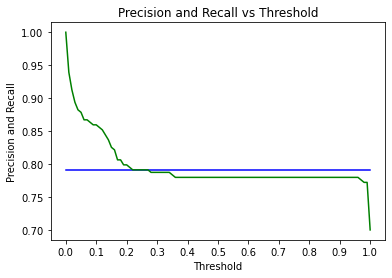

In [50]:
plt.figure(figsize=(6, 4))

plt.plot(thresholds, precision, color='blue')
plt.plot(thresholds, recall, color='green')

plt.title('Precision and Recall vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Precision and Recall')

plt.xticks(np.linspace(0, 1, 11))

# plt.savefig('04_threshold_accuracy.svg')

plt.show()

In [ ]:
# Plot them
# At which threshold precision and recall curves intersect?
# 0.1
# --> 0.3 <--
# 0.6
# 0.8

In [52]:
# Question 4
# Precision and recall are conflicting - when one grows, the other goes down. 
# That's why they are often combined into the F1 score - a metrics that takes into account both
# This is the formula for computing F1:
# F1 = 2 * P * R / (P + R)
# Where P is precision and R is recall.
# Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01
f1 = []
for t in thresholds:
    true_positive = ((card_valid_pred_proba >= t) & (np.array(y_valid) == 1)).sum()
    false_positive = ((card_valid_pred_proba >= t) & (np.array(y_valid) == 0)).sum()
    false_negative = ((card_valid_pred_proba < t) & (np.array(y_valid) == 1)).sum()
    true_negative = ((card_valid_pred_proba < t) & (np.array(y_valid) == 0)).sum()
    prec = true_positive / (true_positive + false_positive)
    reca = true_positive / (true_positive + false_negative)
    #precision.append(prec)
    #recall.append(reca)
    f1_t = 2 * prec * reca / ( prec + reca )
    f1.append(f1_t)
    print('%0.2f %0.3f' % (t, f1_t))

# At which threshold F1 is maximal?
# --> 0.1 <-- # I guess?
# 0.4
# 0.6
# 0.7

0.00 0.884
0.01 0.859
0.02 0.848
0.03 0.840
0.04 0.835
0.05 0.833
0.06 0.828
0.07 0.828
0.08 0.826
0.09 0.824
0.10 0.824
0.11 0.823
0.12 0.821
0.13 0.817
0.14 0.814
0.15 0.808
0.16 0.807
0.17 0.799
0.18 0.799
0.19 0.795
0.20 0.795
0.21 0.794
0.22 0.792
0.23 0.792
0.24 0.792
0.25 0.792
0.26 0.792
0.27 0.792
0.28 0.790
0.29 0.790
0.30 0.790
0.31 0.790
0.32 0.790
0.33 0.790
0.34 0.790
0.35 0.788
0.36 0.786
0.37 0.786
0.38 0.786
0.39 0.786
0.40 0.786
0.41 0.786
0.42 0.786
0.43 0.786
0.44 0.786
0.45 0.786
0.46 0.786
0.47 0.786
0.48 0.786
0.49 0.786
0.50 0.786
0.51 0.786
0.52 0.786
0.53 0.786
0.54 0.786
0.55 0.786
0.56 0.786
0.57 0.786
0.58 0.786
0.59 0.786
0.60 0.786
0.61 0.786
0.62 0.786
0.63 0.786
0.64 0.786
0.65 0.786
0.66 0.786
0.67 0.786
0.68 0.786
0.69 0.786
0.70 0.786
0.71 0.786
0.72 0.786
0.73 0.786
0.74 0.786
0.75 0.786
0.76 0.786
0.77 0.786
0.78 0.786
0.79 0.786
0.80 0.786
0.81 0.786
0.82 0.786
0.83 0.786
0.84 0.786
0.85 0.786
0.86 0.786
0.87 0.786
0.88 0.786
0.89 0.786
0.90 0.786

In [ ]:
# Question 5
# Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:
# KFold(n_splits=5, shuffle=True, random_state=1)
# Iterate over different folds of df_full_train
# Split the data into train and validation
# Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
# Use AUC to evaluate the model on validation
# How large is standard devidation of the AUC scores across different folds?
# 0.003
# 0.014
# 0.09
# 0.24

In [ ]:
# Question 6
# Now let's use 5-Fold cross-validation to find the best parameter C
# Iterate over the following C values: [0.01, 0.1, 1, 10]
# Initialize KFold with the same parameters as previously
# Use these parametes for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
# Compute the mean score as well as the std (round the mean and std to 3 decimal digits)
# Which C leads to the best mean score?
# 0.01
# 0.1
# 1
# 10
# If you have ties, select the score with the lowest std. If you still have ties, select the smallest C